In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
import pandas as pd

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii-Copy1.sqlite", echo=False)

In [6]:
pd.read_sql_table('measurement',engine)
# pd.read_sql_table('station',engine)

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0
...,...,...,...,...,...
19545,19546,USC00516128,2017-08-19,0.09,71.0
19546,19547,USC00516128,2017-08-20,NaN,78.0
19547,19548,USC00516128,2017-08-21,0.56,76.0
19548,19549,USC00516128,2017-08-22,0.50,76.0


In [7]:
pd.read_sql_table('station',engine)

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


In [8]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [9]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date).first()

# let s find the latest date in the dataset
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# print the results 
print(f"First date: {recent_date[0]}, Last date: {last_date[0]} ")

First date: 2010-01-01, Last date: 2017-08-23 


Design a query to retrieve the last 12 months of precipitation data and plot the results. 
Starting from the most recent data point in the database. 
Calculate the date one year from the last date in data set.

In [13]:
new_last_date = dt.datetime.strptime(last_date[0], '%Y-%m-%d')
# let s get the date one year from the last date in the dataset
querydate = dt.date(new_last_date.year -1, new_last_date.month, new_last_date.day)
querydate

#let's retrive the last 12 months of precipitation data
last_12 = [Measurement.date, Measurement.prcp]
#let s query for the result
result = session.query(*last_12).filter(Measurement.date >= querydate).all()

# let s plot the result
precipitation_df = pd.DataFrame(result, columns=['Date','precipitation'])
precipitation_df
# let's get rid of all NAN value
precipitation_df = precipitation_df.dropna(how='any')
precipitation_df
# data is not sorted , let s sort the data
precipitation_df = precipitation_df.sort_values(["Date"], ascending = True)
# let reset our index to get better frame
clean_precipitation_df = precipitation_df.set_index("Date")
clean_precipitation_df.head()


,precipitation
Date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15


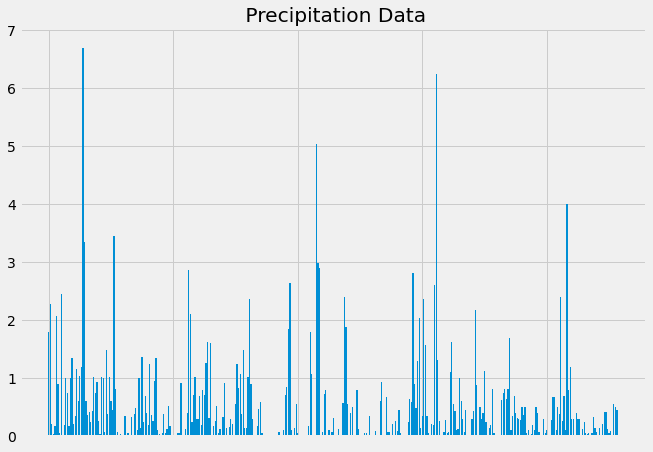

In [14]:
# Use Pandas Plotting with Matplotlib to plot the data
x = clean_precipitation_df.index.tolist()
y = clean_precipitation_df['precipitation'].tolist()

plt.figure(figsize = (10,7))
plt.bar(x,y)
plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)
majorticks = np.arange(0,400,80)
plt.xticks(majorticks)
plt.title(f" Precipitation Data")
plt.show()

Use Pandas to calcualte the summary statistics for the precipitation data


In [15]:
# summary statistics
clean_precipitation_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

Design a query to calculate the total number stations in the dataset


In [16]:
# number of stations
session.query(Station.id).count()

9

Design a query to find the most active stations (i.e. what stations have the most rows?)
List the stations and the counts in descending order.


In [17]:
# most active stations
active_stations = (session.query(Measurement.station, Station.name, func.count(Measurement.id)).filter(Measurement.station == Station.station).group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).all())
print(active_stations)

[('USC00519281', 'WAIHEE 837.5, HI US', 2772), ('USC00519397', 'WAIKIKI 717.2, HI US', 2724), ('USC00513117', 'KANEOHE 838.1, HI US', 2709), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2612), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1979), ('USC00517948', 'PEARL CITY, HI US', 1372), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 511)]


Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

In [18]:
# let's find temperature data
station_temp = (session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs),).filter(Measurement.station == active_stations[0][0]).all())    
print(f" Most active station is {active_stations[0][0]} - {active_stations[0][1]}")
print(f"The lowest tempearture is :{station_temp[0][0]}F , the highest temperature is :{station_temp[0][1]}F, and the average temperature is :{station_temp[0][2]}F")

 Most active station is USC00519281 - WAIHEE 837.5, HI US
The lowest tempearture is :54.0F , the highest temperature is :85.0F, and the average temperature is :71.66378066378067F


Using the most active station id
Query the last 12 months of temperature observation data for this station and plot the results as a histogram

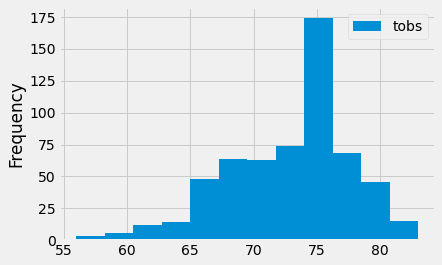

In [19]:

temperature_data = (session.query(Measurement.date, Measurement.tobs).filter(Measurement.date > new_last_date.year -1).filter(Measurement.station == active_stations[0][0]).order_by(Measurement.date).all())
temperature_df = pd.DataFrame(temperature_data)
temperature_df = temperature_df.set_index("date").sort_index(ascending = True)
temperature_df

temperature_df.plot(kind = "hist", bins = 12)
# # x = temperature_df.index.tolist()
# # y = temperature_df['tobs'].tolist()

# # ax.set_xlim(0, 100)
# # ax.set_ylim(0, 100)
# # ax.grid(True)
# # plt.yscale('log')
plt.show()

# Close session

In [20]:
# Close Session
session.close()